In [1]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import subprocess
import whisper
import csv
import ffmpeg


/tmp/ipykernel_295750/4111553420.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(name, sr=None)
/home/dhyan/FullFight/venv/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


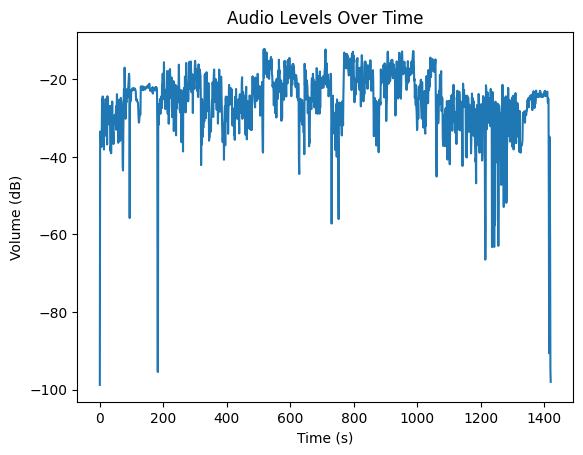

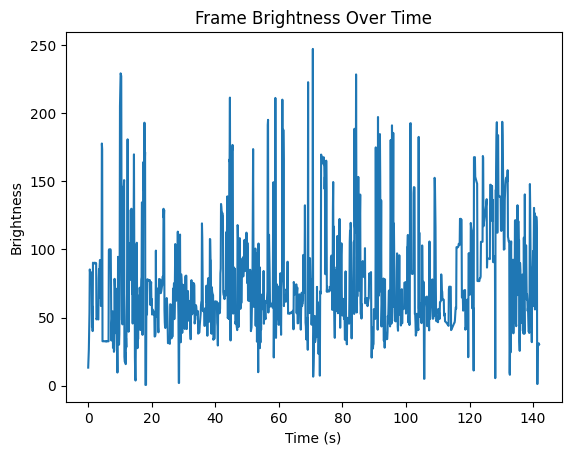

In [ ]:
def get_video(name):
    return "uploads/'" + name + "'"

def plot_time(x, y, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)

def extract_frames(name):
    output_pattern = os.path.join(frame_dir, f"{os.path.basename(name)}_frame_%04d.png")

    ffmpeg.input(name) \
        .output(output_pattern, vf='fps=1') \
        .overwrite_output() \
        .run()


def save_audio_rms_to_csv(name, csv_filename=None, plot=False):
    y, sr = librosa.load(name, sr=None)
    frame_length = int(sr * 1)  # 100ms frames
    hop_length = frame_length

    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    times = librosa.frames_to_time(range(len(rms)), sr=sr, hop_length=hop_length)
    
    if plot:
        plot_time(times, 20 * np.log10(rms), xlabel="Time (s)", ylabel="Volume (dB)", title="Audio Levels Over Time")
    
    if csv_filename is not None:
        with open(csv_filename, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Time (s)", "RMS"])
            for t, r in zip(times, rms):
                writer.writerow([t, r])


# Save frame brightness to CSV only if a filename is explicitly provided
def save_frame_brightness_to_csv(name, csv_filename=None, plot=False):
    brightness_data = []
    if csv_filename is None:
        for fname in sorted(os.listdir(frame_dir)):
            if fname.endswith(".png"):
                img = cv2.imread(os.path.join(frame_dir, fname))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                brightness = np.mean(gray)
                brightness_data.append(brightness)
                
            timestamps = [i * 1 for i in range(len(brightness_data))]

        return brightness_data, timestamps

    for fname in sorted(os.listdir(frame_dir)):
        if fname.endswith(".png"):
            img = cv2.imread(os.path.join(frame_dir, fname))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            brightness = np.mean(gray)
            brightness_data.append(brightness)

    timestamps = [i * 0.1 for i in range(len(brightness_data))]
    with open(csv_filename, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Time (s)", "Brightness"])
        for t, b in zip(timestamps, brightness_data):
            writer.writerow([t, b])
            
    if plot:
        plot_time(timestamps, brightness_data, xlabel="Time (s)", ylabel="Brightness", title="Frame Brightness Over Time")

# Example usage:
# extract_frames("uploads/[Kayoanime] Solo Leveling - S02E06 (1).mkv")
save_audio_rms_to_csv("uploads/[Kayoanime] Solo Leveling - S02E06 (1).mkv", csv_filename="audio_rms.csv", plot=True)
save_frame_brightness_to_csv("uploads/[Kayoanime] Solo Leveling - S02E06 (1).mkv", csv_filename="frame_brightness.csv", plot=True)


In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm

def get_frame_paths(frame_dir, ext="png"):
    frame_paths = sorted(glob.glob(os.path.join(frame_dir, f"*.{ext}")))
    return frame_paths

def compute_optical_flow_magnitude(frame1, frame2):
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        gray1, gray2, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    magnitude = np.sqrt(flow[..., 0]**2 + flow[..., 1]**2)
    return np.mean(magnitude)

def process_motion_from_frames(frame_paths, fps=1, verbose=True):
    motion_scores = []
    total_frames = len(frame_paths)

    for i in tqdm(range(total_frames - 1), desc="Processing frames"):
        frame1 = cv2.imread(frame_paths[i])
        frame2 = cv2.imread(frame_paths[i + 1])

        if frame1 is None or frame2 is None:
            if verbose:
                print(f"Warning: Could not read frame {i} or {i+1}, skipping.")
            continue

        motion = compute_optical_flow_magnitude(frame1, frame2)
        timestamp = round(i / fps, 1)
        motion_scores.append([timestamp, motion])

        if verbose:
            print(f"Processed frames {i} and {i+1} at {timestamp}s: motion={motion:.4f}")

    return pd.DataFrame(motion_scores, columns=["Time (s)", "Motion"])

def save_motion_to_csv(motion_df, output_path="motion.csv"):
    motion_df.to_csv(output_path, index=False)
    print(f"Motion data saved to {output_path} with {len(motion_df)} entries.")

def generate_motion_csv(frame_dir="frames", output_path="motion.csv", fps=1):
    frame_paths = get_frame_paths(frame_dir)
    motion_df = process_motion_from_frames(frame_paths, fps=fps)
    save_motion_to_csv(motion_df, output_path)
    return motion_df

motion_data = generate_motion_csv("frames", "motion.csv", fps=1)

Processed frames 0 and 1 at timestamp 0.0s: motion=0.4733
Processed frames 1 and 2 at timestamp 1.0s: motion=0.6417
Processed frames 2 and 3 at timestamp 2.0s: motion=1.1003
Processed frames 3 and 4 at timestamp 3.0s: motion=1.4120
Processed frames 4 and 5 at timestamp 4.0s: motion=5.0556
Processed frames 5 and 6 at timestamp 5.0s: motion=4.7174
Processed frames 6 and 7 at timestamp 6.0s: motion=0.5656
Processed frames 7 and 8 at timestamp 7.0s: motion=0.0082
Processed frames 8 and 9 at timestamp 8.0s: motion=0.0040
Processed frames 9 and 10 at timestamp 9.0s: motion=4.0300
Processed frames 10 and 11 at timestamp 10.0s: motion=1.8172
Processed frames 11 and 12 at timestamp 11.0s: motion=3.9061
Processed frames 12 and 13 at timestamp 12.0s: motion=1.2591
Processed frames 13 and 14 at timestamp 13.0s: motion=1.6309
Processed frames 14 and 15 at timestamp 14.0s: motion=4.7253
Processed frames 15 and 16 at timestamp 15.0s: motion=5.8087
Processed frames 16 and 17 at timestamp 16.0s: motion

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import datetime
import csv
import whisper

def detect_angry_sections(
    input_video,
    csv_filename="angry_sections.csv",
    anger_threshold=0.1,
    merge_gap=7,
    top_n_sections=None,
    whisper_model_size="base",
    verbose=True
):
    # Load Whisper
    model = whisper.load_model(whisper_model_size)
    result = model.transcribe(input_video)

    # Load emotion classifier
    if verbose: print("Loading emotion classifier...")
    tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
    emotion_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
    labels = ['anger', 'joy', 'optimism', 'sadness']

    angry_segments = []

    for seg in result["segments"]:
        text = seg["text"]
        start = seg["start"]
        end = seg["end"]

        inputs = tokenizer(text, return_tensors="pt", truncation=True)
        with torch.no_grad():
            logits = emotion_model(**inputs).logits
            probs = F.softmax(logits, dim=1)[0]

        anger_score = probs[labels.index("anger")].item()

        if anger_score > anger_threshold:
            angry_segments.append({
                "start": start,
                "end": end,
                "text": text.strip(),
                "anger_score": anger_score
            })

    grouped_angry_sections = []
    if angry_segments:
        current_group = [angry_segments[0]]
        for seg in angry_segments[1:]:
            if seg['start'] - current_group[-1]['end'] <= merge_gap:
                current_group.append(seg)
            else:
                grouped_angry_sections.append(current_group)
                current_group = [seg]
        grouped_angry_sections.append(current_group)

    def sec_to_mmss(sec):
        return str(datetime.timedelta(seconds=int(sec)))

    ranked_sections = []
    for group in grouped_angry_sections:
        start = group[0]['start']
        end = group[-1]['end']
        avg_anger = sum(s['anger_score'] for s in group) / len(group)
        ranked_sections.append({
            "start": start,
            "end": end,
            "avg_anger": avg_anger,
            "segments": group
        })

    ranked_sections.sort(key=lambda x: x["avg_anger"], reverse=True)

    if verbose:
        print("\nAngriest Sections in the Video:\n")
        for i, section in enumerate(ranked_sections if top_n_sections is None else ranked_sections[:top_n_sections]):
            print(f"Section {i+1}")
            print(f"[{sec_to_mmss(section['start'])} → {sec_to_mmss(section['end'])}] | Avg Anger Score: {section['avg_anger']:.2f}\n")
            for seg in section["segments"]:
                print(f"[{sec_to_mmss(seg['start'])} → {sec_to_mmss(seg['end'])}] | Anger: {seg['anger_score']:.2f}")
                print(f"{seg['text']}\n")
            print("------------------------------------------------------------\n")

    with open(csv_filename, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([
            "Section Number",
            "Section Start",
            "Section End",
            "Section Avg Anger",
            "Segment Start",
            "Segment End",
            "Segment Anger Score",
            "Segment Text"
        ])

        for i, section in enumerate(ranked_sections if top_n_sections is None else ranked_sections[:top_n_sections], start=1):
            section_start = sec_to_mmss(section["start"])
            section_end = sec_to_mmss(section["end"])
            avg_anger = f"{section['avg_anger']:.2f}"

            for seg in section["segments"]:
                seg_start = sec_to_mmss(seg["start"])
                seg_end = sec_to_mmss(seg["end"])
                seg_anger = f"{seg['anger_score']:.2f}"
                seg_text = seg["text"].replace('\n', ' ').strip()
                writer.writerow([
                    i,
                    section_start,
                    section_end,
                    avg_anger,
                    seg_start,
                    seg_end,
                    seg_anger,
                    seg_text
                ])

    return ranked_sections

ranked_angry = detect_angry_sections(
    input_video="uploads/episode6.mkv",
    csv_filename="angry_sections.csv",
    anger_threshold=0.1,
    merge_gap=7,
    top_n_sections=5,
    whisper_model_size="base"
)

Loading emotion classifier...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Angriest Sections in the Video:

🔴 Section 1
[0:16:06 → 0:16:08] | Avg Anger Score: 0.85

  🕒 [0:16:06 → 0:16:08] | Anger: 0.85
  🗣️  If daggers aren't enough

------------------------------------------------------------

🔴 Section 2
[0:13:50 → 0:14:02] | Avg Anger Score: 0.61

  🕒 [0:13:50 → 0:13:54] | Anger: 0.75
  🗣️  But I'm pretty resistant to curses and poison

  🕒 [0:13:54 → 0:13:58] | Anger: 0.13
  🗣️  Oh, hold up, Guardian!

  🕒 [0:13:58 → 0:14:02] | Anger: 0.96
  🗣️  Alright man, I'm gonna break that annoying shield of yours

------------------------------------------------------------

🔴 Section 3
[0:16:16 → 0:16:18] | Avg Anger Score: 0.53

  🕒 [0:16:16 → 0:16:18] | Anger: 0.53
  🗣️  Feld away

------------------------------------------------------------

🔴 Section 4
[0:04:51 → 0:05:03] | Avg Anger Score: 0.53

  🕒 [0:04:51 → 0:04:53] | Anger: 0.91
  🗣️  You fool

  🕒 [0:04:53 → 0:04:55] | Anger: 0.79
  🗣️  Anti-gravel

  🕒 [0:04:57 → 0:05:00] | Anger: 0.28
  🗣️  Gravity a

In [ ]:
import csv
import datetime
import numpy as np

def mmss_to_seconds(time_str):
    t = datetime.datetime.strptime(time_str, "%H:%M:%S")
    return t.minute * 60 + t.second

def interpolate_numeric_field(data, key):
    times = [entry["time"] for entry in data]
    values = [entry[key] if isinstance(entry[key], float) else np.nan for entry in data]
    interpolated = np.interp(
        times,
        [t for t, v in zip(times, values) if not np.isnan(v)],
        [v for v in values if not np.isnan(v)]
    )
    for i, val in enumerate(values):
        if np.isnan(val):
            data[i][key] = round(interpolated[i], 6)

def merge_features_to_csv(
    anger_csv="angry_sections.csv",
    motion_csv="motion.csv",
    rms_csv="audio_rms.csv",
    brightness_csv="frame_brightness.csv",
    output_csv="normalized_merged_data.csv",
    time_step=0.1,
    interpolate_anger=True,
    verbose=True
):
    angry_segments = []
    with open(anger_csv, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            angry_segments.append({
                "section": int(row["Section Number"]),
                "start": mmss_to_seconds(row["Segment Start"]),
                "end": mmss_to_seconds(row["Segment End"]),
                "text": row["Segment Text"],
                "anger": float(row["Segment Anger Score"]),
            })

    def load_scalar_csv(path, key_name):
        data = {}
        with open(path, newline='') as f:
            reader = csv.DictReader(f)
            for row in reader:
                time = float(row["Time (s)"])
                data[round(time, 1)] = float(row[key_name])
        return data

    motion_data = load_scalar_csv(motion_csv, "Motion")
    rms_data = load_scalar_csv(rms_csv, "RMS")
    brightness_data = load_scalar_csv(brightness_csv, "Brightness")

    min_time = 0.0
    max_time = max(
        max(rms_data.keys(), default=0),
        max(brightness_data.keys(), default=0),
        max((seg["end"] for seg in angry_segments), default=0)
    )

    all_times = np.round(np.arange(min_time, max_time + time_step, time_step), 1)

    merged = []
    for t in all_times:
        section = ""
        text = ""
        anger = "n/a"

        for seg in angry_segments:
            if seg["start"] <= t <= seg["end"]:
                section = seg["section"]
                text = seg["text"]
                anger = seg["anger"]
                break

        rms = rms_data.get(t, "n/a")
        brightness = brightness_data.get(t, "n/a")
        motion = motion_data.get(t, "n/a")

        merged.append({
            "time": t,
            "section": section,
            "text": text,
            "anger": anger,
            "rms": rms,
            "brightness": brightness,
            "motion": motion
        })

    interpolate_numeric_field(merged, "rms")
    interpolate_numeric_field(merged, "brightness")
    interpolate_numeric_field(merged, "motion")
    if interpolate_anger:
        interpolate_numeric_field(merged, "anger")

    with open(output_csv, "w", newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["Time (s)", "Section", "Text", "Anger Score", "RMS", "Brightness", "Motion"])
        for row in merged:
            writer.writerow([
                f"{row['time']:.1f}",
                row["section"],
                row["text"],
                f"{row['anger']:.4f}" if isinstance(row["anger"], float) else row["anger"],
                f"{row['rms']:.6f}" if isinstance(row["rms"], float) else row["rms"],
                f"{row['brightness']:.6f}" if isinstance(row["brightness"], float) else row["brightness"],
                f"{row['motion']:.6f}" if isinstance(row["motion"], float) else row["motion"],
            ])

    if verbose:
        print(f"Saved merged and interpolated features to {output_csv}")

merge_features_to_csv(
    anger_csv="angry_sections.csv",
    motion_csv="motion.csv",
    rms_csv="audio_rms.csv",
    brightness_csv="frame_brightness.csv",
    output_csv="normalized_merged_data.csv"
)

In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

# Load data
df = pd.read_csv("normalized_merged_data.csv")

# Drop rows with missing values
df = df[(df["Anger Score"] != 'n/a') & (df["RMS"] != 'n/a') & (df["Brightness"] != 'n/a')]

# Convert to floats
df["Anger Score"] = df["Anger Score"].astype(float)
df["RMS"] = df["RMS"].astype(float)
df["Brightness"] = df["Brightness"].astype(float)
df["Motion"] = df["Motion"].astype(float)

# Label fight scenes using quantiles
anger_thresh = df["Anger Score"].quantile(0.8)
rms_thresh = df["RMS"].quantile(0.75)
brightness_thresh = df["Brightness"].quantile(0.75)
motion_thresh = df["Motion"].quantile(0.5)

# Define fight scene label
df["Fight Scene"] = (
    (df["Anger Score"] >= anger_thresh) &
    (df["RMS"] >= rms_thresh) &
    (df["Brightness"] >= brightness_thresh) &
    (df["Motion"] >= motion_thresh)
).astype(int)

# Train Random Forest Classifier
X = df[["Anger Score", "RMS", "Brightness", "Motion"]]
y = df["Fight Scene"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

# Predict fight scene probabilities for all data
df["Fight Probability"] = clf.predict_proba(X)[:, 1]

# Choose high confidence predictions
fight_df = df[df["Fight Probability"] > 0.8]  # adjust if needed
fight_df = fight_df.sort_values("Time (s)")

# Select timestamps spaced >= 10 seconds apart
selected_times = []
last_time = -float('inf')
for t in fight_df["Time (s)"]:
    if t - last_time >= 10:
        selected_times.append(t)
        last_time = t

# Output final fight scene timestamps
print("Probable Fight Scene Timestamps (seconds):")
for t in selected_times:
    print(f"{t:.1f}")

joblib.dump(clf, "rf_fight_scene_model.pkl")

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2753
           1     1.0000    1.0000    1.0000        88

    accuracy                         1.0000      2841
   macro avg     1.0000    1.0000    1.0000      2841
weighted avg     1.0000    1.0000    1.0000      2841

Probable Fight Scene Timestamps (seconds):
91.4
218.6
904.9
914.9
949.6
959.6
969.6
981.6
1040.5
1052.2
1073.5


['rf_fight_scene_model.pkl']